In [1]:
import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
import sys

sys.path.insert(1, str(Path().cwd().parent))
import common_config

In [2]:
common_config.figure_journal_basic()

In [3]:
import pertpy as pt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from tqdm import tqdm

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [4]:
adata = pt.dt.mcfarland_2020()
adata

AnnData object with n_obs × n_vars = 182875 × 32738
    obs: 'DepMap_ID', 'cancer', 'cell_det_rate', 'cell_line', 'cell_quality', 'channel', 'disease', 'dose_unit', 'dose_value', 'doublet_CL1', 'doublet_CL2', 'doublet_GMM_prob', 'doublet_dev_imp', 'doublet_z_margin', 'hash_assignment', 'hash_tag', 'num_SNPs', 'organism', 'percent.mito', 'perturbation', 'perturbation_type', 'sex', 'singlet_ID', 'singlet_dev', 'singlet_dev_z', 'singlet_margin', 'singlet_z_margin', 'time', 'tissue_type', 'tot_reads', 'nperts', 'ngenes', 'ncounts', 'percent_mito', 'percent_ribo', 'chembl-ID'
    var: 'ensembl_id', 'ncounts', 'ncells'

In [5]:
cl_metadata = pt.md.CellLine()
cl_metadata.annotate(
    adata,
    query_id="DepMap_ID",
    reference_id="ModelID",
    cell_line_source="DepMap",
    fetch=["StrippedCellLineName"],
)
adata

AnnData object with n_obs × n_vars = 182875 × 32738
    obs: 'DepMap_ID', 'cancer', 'cell_det_rate', 'cell_line', 'cell_quality', 'channel', 'disease', 'dose_unit', 'dose_value', 'doublet_CL1', 'doublet_CL2', 'doublet_GMM_prob', 'doublet_dev_imp', 'doublet_z_margin', 'hash_assignment', 'hash_tag', 'num_SNPs', 'organism', 'percent.mito', 'perturbation', 'perturbation_type', 'sex', 'singlet_ID', 'singlet_dev', 'singlet_dev_z', 'singlet_margin', 'singlet_z_margin', 'time', 'tissue_type', 'tot_reads', 'nperts', 'ngenes', 'ncounts', 'percent_mito', 'percent_ribo', 'chembl-ID', 'StrippedCellLineName'
    var: 'ensembl_id', 'ncounts', 'ncells'

In [6]:
#cl_metadata = pt.md.CellLine()
cl_metadata.annotate(
    adata,
    query_id="StrippedCellLineName",
    reference_id="StrippedCellLineName",
    cell_line_source="Cancerrxgene",
    fetch=["cell_line_name"],
)
adata

💡 There are 209 identifiers in `adata.obs`.However, 73 identifiers can't be found in the cell line annotation,leading to the presence of NA values for their respective metadata.
Please check again: *unmatched_identifiers[:verbosity]...


AnnData object with n_obs × n_vars = 182875 × 32738
    obs: 'DepMap_ID', 'cancer', 'cell_det_rate', 'cell_line', 'cell_quality', 'channel', 'disease', 'dose_unit', 'dose_value', 'doublet_CL1', 'doublet_CL2', 'doublet_GMM_prob', 'doublet_dev_imp', 'doublet_z_margin', 'hash_assignment', 'hash_tag', 'num_SNPs', 'organism', 'percent.mito', 'perturbation', 'perturbation_type', 'sex', 'singlet_ID', 'singlet_dev', 'singlet_dev_z', 'singlet_margin', 'singlet_z_margin', 'time', 'tissue_type', 'tot_reads', 'nperts', 'ngenes', 'ncounts', 'percent_mito', 'percent_ribo', 'chembl-ID', 'StrippedCellLineName', 'cell_line_name'
    var: 'ensembl_id', 'ncounts', 'ncells'

In [7]:
#cl_metadata = pt.md.CellLine()
cl_metadata.annotate_from_gdsc(
    adata,
    query_id="cell_line_name",
    reference_id="cell_line_name",
    query_perturbation='perturbation',
    gdsc_dataset=1,
)
adata

💡 There are 137 identifiers in `adata.obs`.However, 1 identifiers can't be found in the drug response annotation,leading to the presence of NA values for their respective metadata.
Please check again: *unmatched_identifiers[:verbosity]...


AnnData object with n_obs × n_vars = 182875 × 32738
    obs: 'cell_line_name', 'perturbation', 'DepMap_ID', 'cancer', 'cell_det_rate', 'cell_line', 'cell_quality', 'channel', 'disease', 'dose_unit', 'dose_value', 'doublet_CL1', 'doublet_CL2', 'doublet_GMM_prob', 'doublet_dev_imp', 'doublet_z_margin', 'hash_assignment', 'hash_tag', 'num_SNPs', 'organism', 'percent.mito', 'perturbation_type', 'sex', 'singlet_ID', 'singlet_dev', 'singlet_dev_z', 'singlet_margin', 'singlet_z_margin', 'time', 'tissue_type', 'tot_reads', 'nperts', 'ngenes', 'ncounts', 'percent_mito', 'percent_ribo', 'chembl-ID', 'StrippedCellLineName', 'ln_ic50'
    var: 'ensembl_id', 'ncounts', 'ncells'

In [9]:
adata.obs["ln_ic50_GDSC1"] = adata.obs["ln_ic50"].copy()

In [10]:
cl_metadata.annotate_from_gdsc(
    adata,
    query_id="cell_line_name",
    reference_id="cell_line_name",
    query_perturbation='perturbation',
    gdsc_dataset=2,
)
adata

💡 There are 137 identifiers in `adata.obs`.However, 1 identifiers can't be found in the drug response annotation,leading to the presence of NA values for their respective metadata.
Please check again: *unmatched_identifiers[:verbosity]...


AnnData object with n_obs × n_vars = 182875 × 32738
    obs: 'cell_line_name', 'perturbation', 'DepMap_ID', 'cancer', 'cell_det_rate', 'cell_line', 'cell_quality', 'channel', 'disease', 'dose_unit', 'dose_value', 'doublet_CL1', 'doublet_CL2', 'doublet_GMM_prob', 'doublet_dev_imp', 'doublet_z_margin', 'hash_assignment', 'hash_tag', 'num_SNPs', 'organism', 'percent.mito', 'perturbation_type', 'sex', 'singlet_ID', 'singlet_dev', 'singlet_dev_z', 'singlet_margin', 'singlet_z_margin', 'time', 'tissue_type', 'tot_reads', 'nperts', 'ngenes', 'ncounts', 'percent_mito', 'percent_ribo', 'chembl-ID', 'StrippedCellLineName', 'ln_ic50', 'ln_ic50_GDSC1'
    var: 'ensembl_id', 'ncounts', 'ncells'

<Axes: >

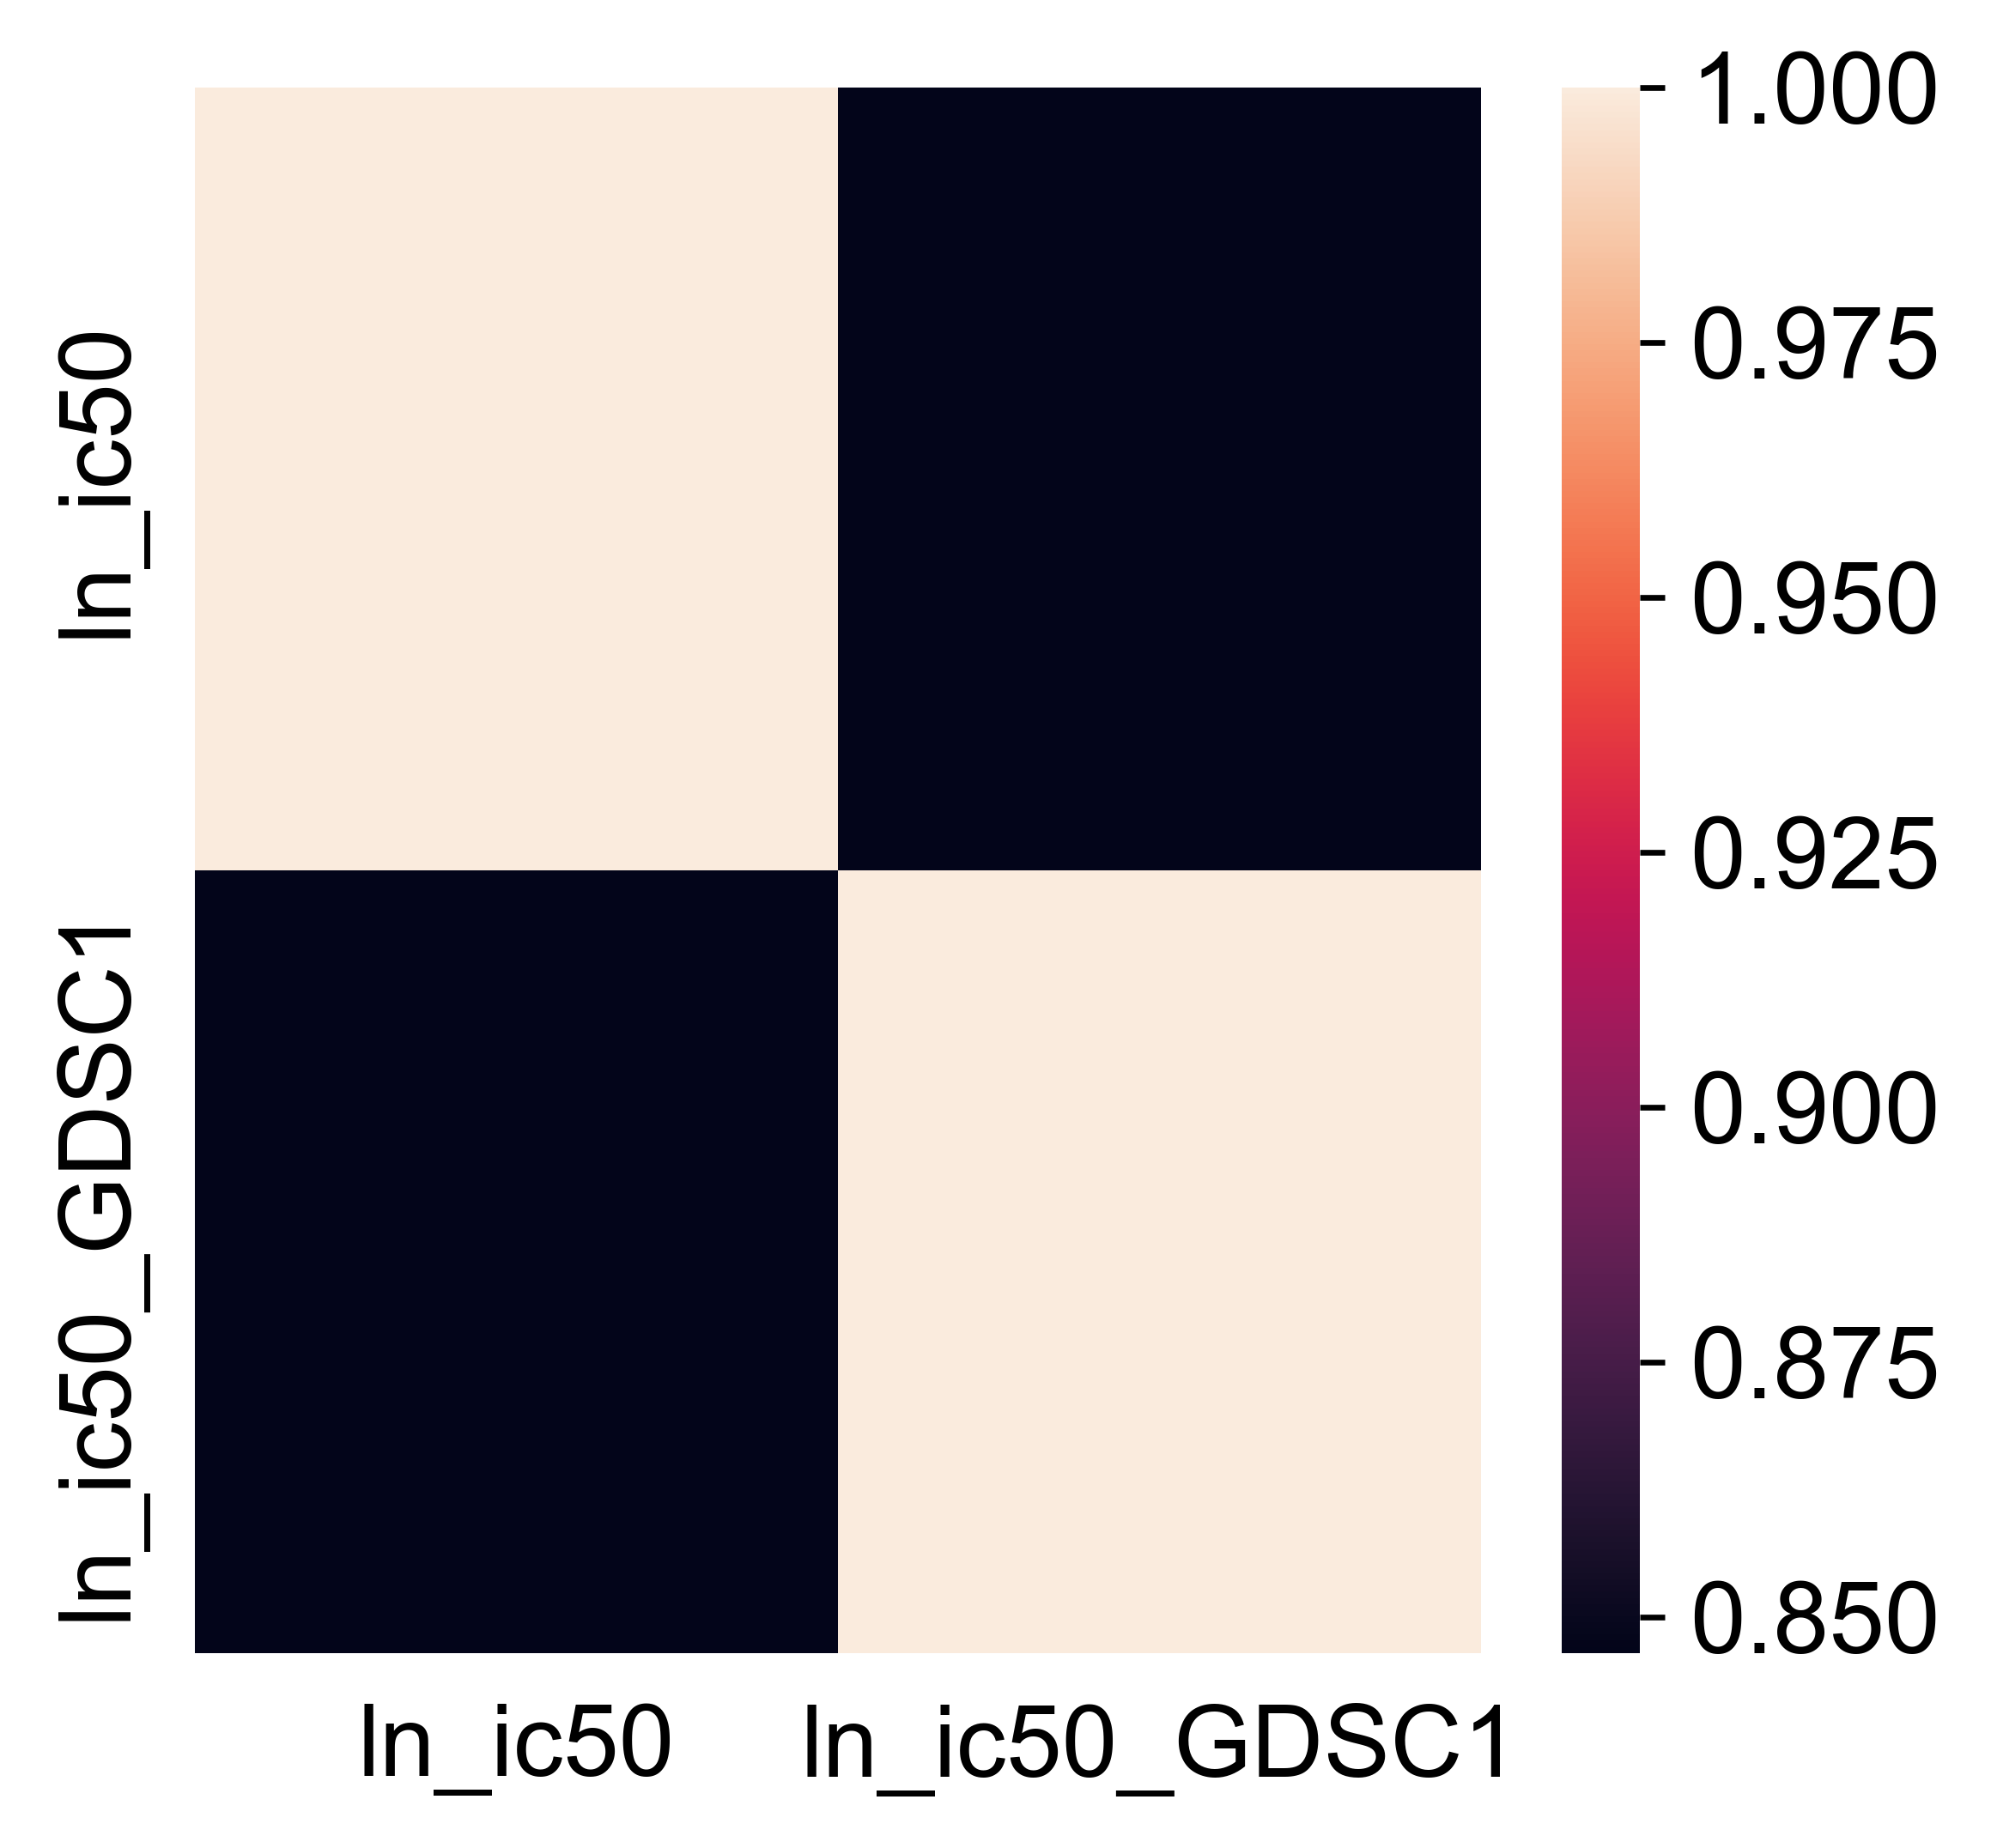

In [12]:
sns.heatmap(adata.obs[["ln_ic50", "ln_ic50_GDSC1"]].corr())

In [85]:
adata.obs[["GDSC2", "CellLineName", "perturbation"]].drop_duplicates().sort_values("CellLineName")

,GDSC2,CellLineName,perturbation
AAAGCAACAATCCAAC,282.0,22Rv1,control
AAAGTAGAGTTAAGTG-1,282.0,22Rv1,Trametinib
AAAGATGCACCTATCC,282.0,22Rv1,BRD3379
AAACGGGTCACGCATA,282.0,22Rv1,Navitoclax
AAACGGGGTAAAGTCA,282.0,22Rv1,Dabrafenib
...,...,...,...
AAAGATGGTGCGGTAA,NaN,YD-15,sgLACZ
AAACGGGCAATTCCTT,NaN,YD-38,sgGPX4-1
AAACGGGCAGCTTCGG,NaN,YD-38,sgOR2J2
AAACCTGTCTGCTGTC,NaN,YD-38,sgLACZ


In [50]:
adata = adata[adata.obs["perturbation"].isin(["control", "Trametinib"])]
adata

View of AnnData object with n_obs × n_vars = 70443 × 4000
    obs: 'DepMap_ID', 'cancer', 'cell_det_rate', 'cell_line', 'cell_quality', 'channel', 'disease', 'dose_unit', 'dose_value', 'doublet_CL1', 'doublet_CL2', 'doublet_GMM_prob', 'doublet_dev_imp', 'doublet_z_margin', 'hash_assignment', 'hash_tag', 'num_SNPs', 'organism', 'percent.mito', 'perturbation', 'perturbation_type', 'sex', 'singlet_ID', 'singlet_dev', 'singlet_dev_z', 'singlet_margin', 'singlet_z_margin', 'time', 'tissue_type', 'tot_reads', 'nperts', 'ngenes', 'ncounts', 'percent_mito', 'percent_ribo', 'chembl-ID', 'PatientID', 'CellLineName', 'StrippedCellLineName', 'DepmapModelType', 'OncotreeLineage', 'OncotreePrimaryDisease', 'OncotreeSubtype', 'OncotreeCode', 'LegacyMolecularSubtype', 'PatientMolecularSubtype', 'RRID', 'Age', 'AgeCategory', 'Sex', 'PatientRace', 'PrimaryOrMetastasis', 'SampleCollectionSite', 'SourceType', 'SourceDetail', 'TreatmentStatus', 'TreatmentDetails', 'GrowthPattern', 'OnboardedMedia', 'Formul

In [60]:
logfc_df = pd.DataFrame(columns=adata.var_names)

for cell_line in tqdm(adata.obs["CellLineName"].unique()[:50]):
    #TODO: Check if sufficient cell numbers
    
    subset = adata[adata.obs["CellLineName"] == cell_line]
    
    edgr = pt.tl.EdgeR(subset, design="~perturbation")
    edgr.fit()
    res_df = edgr.test_contrasts(edgr.contrast("perturbation", "Trametinib", "control"))
    res_df = res_df[["variable", "log_fc"]]
    res_df = res_df.set_index("variable")
    res_df = res_df.reindex(adata.var_names)
    logfc_df.loc[cell_line] = res_df["log_fc"]

NCI-H226
SH-10-TC
UM-UC-1
COLO-680N
DK-MG
NCI-H2347
RCC10RGB
SK-MEL-3
CCF-STTG1
BICR 6
IA-LM
LS1034
BICR 31
RCM-1
COV434
TEN
LNCaP clone FGC
Sq-1
SNU-1079
Caov-3
SK-MEL-2
BT-549
RERF-LC-Ad1
BT-474
UACC-257
HEC-1-B
LoVo
KYSE-270
OS-RC-2
NCI-H2444
HCC1419
MSTO-211H
Hs 766T
CAL-62
8505C
G-401
MIA PaCa-2
NCI-H522
LN-229
LMSU
NCI-H1299
OAW42


KeyboardInterrupt: 

In [62]:
logfc_df

,RP11-206L10.2,SAMD11,HES4,ISG15,RNF223,RP11-465B22.5,RP11-465B22.8,MIB2,C1orf222,HES5,...,MT-ND2,MT-CO2,MT-ATP8,MT-ATP6,MT-CO3,MT-ND3,MT-ND4L,MT-ND5,MT-ND6,MT-CYB
NCI-H226,-0.056631,0.023854,0.778960,-0.855945,-0.063421,0.000000e+00,-0.071028,0.050090,-0.040887,0.000000e+00,...,0.293481,-0.626264,-3.170935,-1.749683,-0.747202,-2.538509,-2.351973,-1.079924,-2.228786,-0.716406
SH-10-TC,-0.120489,-1.261185,0.576117,-0.568203,-0.121803,0.000000e+00,-0.062605,-0.102929,-0.033516,6.964794e-02,...,0.272754,-0.497946,-3.047496,-1.376556,-0.686781,-1.810955,-1.802992,-1.022164,-1.613436,-0.907332
UM-UC-1,-0.094179,-0.114638,0.026912,-1.586141,-0.255570,0.000000e+00,-0.139468,0.266755,0.053381,3.753169e-02,...,0.718344,-0.384176,-3.192004,-1.408674,-0.553507,-1.880864,-1.997774,-0.871288,-1.438610,-0.512293
COLO-680N,-0.107592,-0.323277,0.128009,-0.029667,-0.245211,0.000000e+00,-0.253580,-0.284287,-0.121957,2.716157e-02,...,-0.054034,-0.997626,-3.050796,-1.363295,-0.819858,-2.082945,-2.003205,-1.388538,-1.542712,-0.926313
DK-MG,-0.056114,-0.473638,0.552485,0.042384,-0.094361,0.000000e+00,-0.086269,0.021629,0.037938,-8.849700e-03,...,0.185814,-0.715760,-2.602113,-1.445007,-0.680561,-1.911512,-2.054348,-1.234275,-2.076624,-0.546617
NCI-H2347,-0.053592,0.059266,0.342833,-0.302170,0.028130,0.000000e+00,-0.003555,0.126241,-0.010580,-5.058429e-02,...,0.270400,-0.526639,-2.548818,-1.217023,-0.633051,-1.764605,-1.479840,-0.732152,-1.291752,-0.600031
RCC10RGB,-0.023800,-0.454539,0.478512,-0.541704,-0.044211,-3.408774e-03,0.038228,0.195526,-0.015482,-1.619044e-02,...,-0.347850,-1.172344,-3.375559,-1.666354,-1.036784,-2.811021,-2.181234,-1.251064,-1.862049,-1.156700
SK-MEL-3,-0.006644,-0.215910,0.435914,-1.178182,-0.045498,2.562741e-15,-0.092931,-0.150749,-0.015218,2.562741e-15,...,-0.170480,-0.482913,-3.766592,-1.490813,-0.782637,-2.617527,-2.560892,-1.435374,-2.626832,-0.715016
CCF-STTG1,-0.040550,-0.555580,0.172740,-0.152373,0.036757,0.000000e+00,-0.173892,-0.003756,-0.012629,-3.838147e-02,...,-0.181175,-1.174329,-3.050678,-1.907138,-1.134511,-3.030060,-2.449384,-1.439305,-2.317940,-1.175529
BICR 6,-0.082542,-0.143272,0.437642,-0.903568,0.036866,0.000000e+00,0.022841,1.063609,-0.139794,2.585917e-01,...,0.202163,-0.945855,-2.437887,-1.537766,-0.824780,-1.928303,-1.798986,-0.751573,-0.973217,-1.159749


In [67]:
lr_params = pd.DataFrame(columns=["gene", "slope", "intercept"])

lr = LinearRegression()
cell_lines = logfc_df.index
X = adata.obs[["GDSC2", "CellLineName"]].drop_duplicates().set_index("CellLineName").loc[cell_lines]["GDSC2"].values
na_mask = np.isnan(X)
X = X[~na_mask]

for gene in adata.var_names:
    y = logfc_df[gene].values
    y = y[~na_mask]
    lr.fit(X.reshape(-1, 1), y)
    
    assert len(lr.coef_) == 1
    lr_params.loc[gene] = [gene, lr.coef_[0], lr.intercept_]

In [68]:
lr_params

,gene,slope,intercept
RP11-206L10.2,RP11-206L10.2,0.000055,-0.038561
SAMD11,SAMD11,-0.001939,0.042681
HES4,HES4,0.001129,-0.161269
ISG15,ISG15,0.000550,-0.943200
RNF223,RNF223,0.001640,-0.470125
...,...,...,...
MT-ND3,MT-ND3,0.002859,-1.978215
MT-ND4L,MT-ND4L,0.002323,-1.415792
MT-ND5,MT-ND5,0.000100,-0.481951
MT-ND6,MT-ND6,0.003251,-1.553424


In [72]:
lr_params.loc["EGR1"]

gene             EGR1
slope        0.002707
intercept     0.07311
Name: EGR1, dtype: object

In [71]:
"EGR1" in adata.var_names

True

GDSC2
CellLineName perturbation       
22Rv1        Trametinib       84
             control         158
253J-BV      Trametinib        0
             control           0
42-MG-BA     Trametinib      192
...                          ...
UM-UC-1      control           0
WM-266-4     Trametinib        0
             control           0
WM1799       Trametinib        0
             control           0

[342 rows x 1 columns]